Oliver James Tan and Chieu Le Heng

We look at dataset of 398 car brands from https://www.kaggle.com/uciml/autompg-dataset/. 

### Attributes
`mpg`: miles per gallon (fuel efficiency)
`cylinders`: # cylinders
`displacement`: engine displacement (cu. inches)
`horsepower`:
`weight`: in lbs
`acceleration`: time (s) taken to accelerate from 0mph to 60mph
`model year`
`origin`: 1 is a car made in America, 2 in Europe and 3 in Japan. Note this info is a summary of `car name`
`car name`: brand name

We try to
1. (supervised) predict `mpg` from other attributes 
2. (supervised) classify the vehicles
3. (unsupervised) cluster the vehicles

# 1. Data cleaning
1) One-hot encoding of car name

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency, linregress
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
df = pd.read_csv('auto-mpg-cleaned.csv', na_values='?')
mask = df.columns.isin(['mpg', 'horsepower', 'weight', 'acceleration'])
df.loc[:, mask].corr()
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df['model year'] = df['model year'] + 1900

df['origin_1'] = df['origin']==1
df['origin_2'] = df['origin']==2
df['origin_3'] = df['origin']==3

df['brand'] = pd.DataFrame([i.split(' ')[0] for i in df['car name'].values])
dict_ = dict((brand, i) for i, brand in enumerate(df['brand'].unique()))
df['brand_id'] = pd.DataFrame(dict_[brand] for brand in df['brand'].values)

In [2]:
# look at brands distribution
cnt = {}
for brand in df['brand'].values:
    if brand not in cnt: cnt[brand] = 0
    cnt[brand] += 1
print(*sorted((count, brand) for brand, count in cnt.items()), sep='\n')

(1, 'capri')
(1, 'hi')
(1, 'nissan')
(1, 'triumph')
(2, 'bmw')
(2, 'cadillac')
(2, 'maxda')
(3, 'chevy')
(3, 'mercedes-benz')
(3, 'renault')
(4, 'opel')
(4, 'saab')
(4, 'subaru')
(5, 'vw')
(6, 'chrysler')
(6, 'volvo')
(7, 'audi')
(8, 'fiat')
(8, 'peugeot')
(10, 'mazda')
(10, 'oldsmobile')
(11, 'mercury')
(13, 'honda')
(16, 'pontiac')
(17, 'buick')
(17, 'volkswagen')
(23, 'datsun')
(26, 'toyota')
(27, 'amc')
(28, 'dodge')
(31, 'plymouth')
(44, 'chevrolet')
(48, 'ford')


In [3]:
# create new DataFrame without minor brands 
minor_brands = [brand for brand, count in cnt.items() if count<10]
df_major = df.loc[~df.brand.isin(minor_brands), :]

In [4]:
# summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
 9   origin_1      392 non-null    bool   
 10  origin_2      392 non-null    bool   
 11  origin_3      392 non-null    bool   
 12  brand         392 non-null    object 
 13  brand_id      392 non-null    int64  
dtypes: bool(3), float64(4), int64(5), object(2)
memory usage: 35.0+ KB


# 2. Visualisation and Correlation
1) Correlation pairwise between discrete and pairwise between continuous variables. (Done mainly for statistics project)

                            mpg                  horsepower                 weight                acceleration       
mpg            |                           -24.489, 0.606, 0.000    -29.645, 0.693, 0.000      9.228, 0.179, 0.000    
horsepower     |  -24.489, 0.606, 0.000                              33.972, 0.747, 0.000    -18.784, 0.475, 0.000    
weight         |  -29.645, 0.693, 0.000     33.972, 0.747, 0.000                              -9.056, 0.174, 0.000    
acceleration   |    9.228, 0.179, 0.000    -18.784, 0.475, 0.000     -9.056, 0.174, 0.000                             


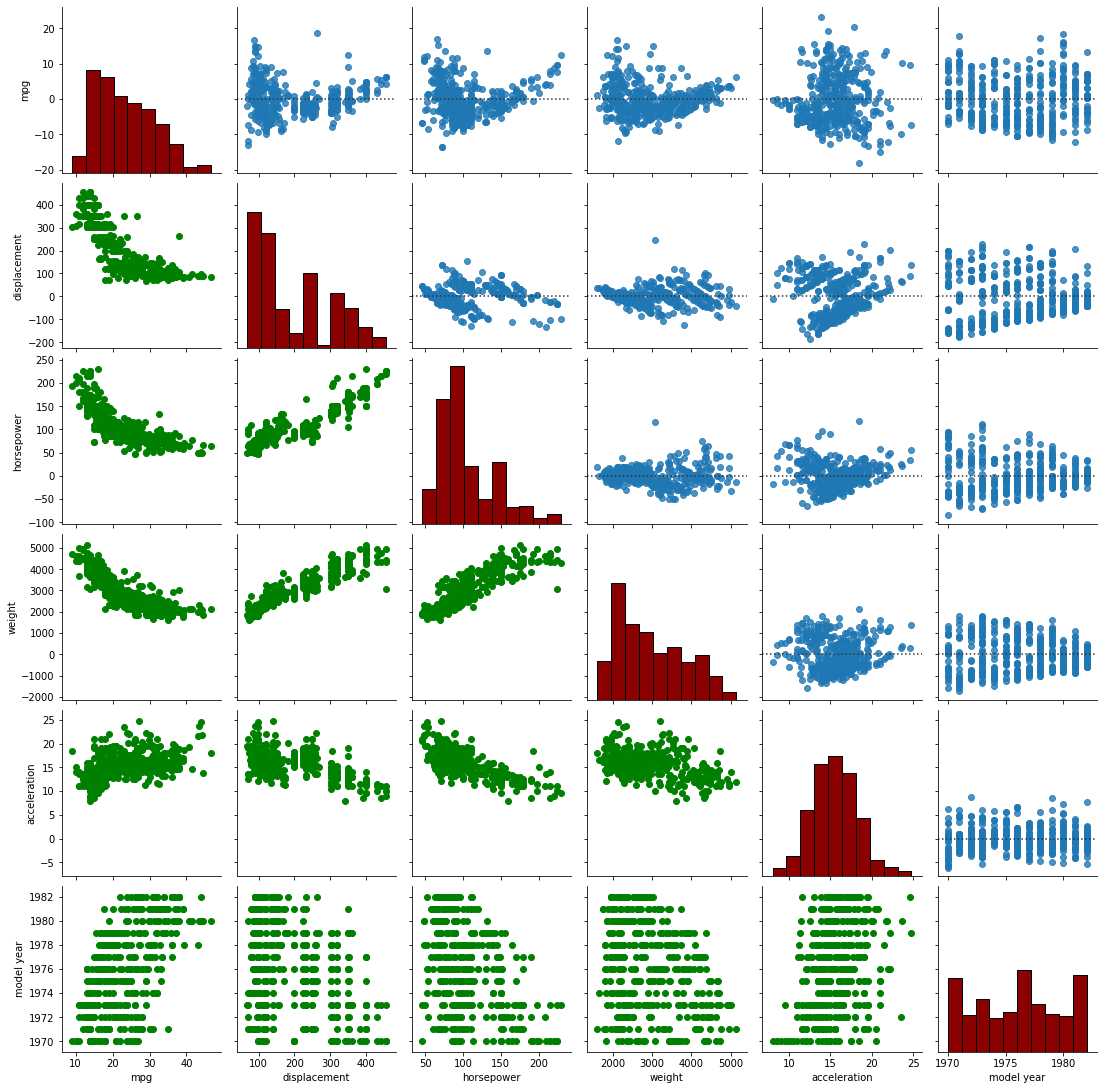

In [5]:
cols = df['mpg'], df['horsepower'], df['weight'], df['acceleration']
print(' '*17, end='')
for col1 in cols:
    print(f'{col1.name:^25}', end='')
print()

for col0 in cols:
    print(f'{col0.name:15}|', end='  ')
    for col1 in cols:
        if col0 is col1:
            print(' '*25, end='')
            continue
        regr = linregress(col0, col1)
        print('{:7.3f}, {:5.3f}, {:5.3f}'.format(regr.slope/regr.stderr, regr.rvalue**2, regr.pvalue), end='    ')
        #print(pearsonr(col0, col1), end=' ')
    print()

# HISTOGRAMS, SCATTERPLOTS AND RESIDUAL PLOTS
grid = sns.PairGrid(data= df, vars = ['mpg', 'displacement', 'horsepower',  'weight', 'acceleration', 'model year'])
grid = grid.map_upper(sns.residplot)
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
grid = grid.map_lower(plt.scatter, color='green')
plt.show()

7 out of 392 data points removed
Observed
        |  1970  |  1971  |  1972  |  1973  |  1974  |  1975  |  1976  |  1977  |  1978  |  1979  |  1980  |  1981  |  1982  | Total  | 
      4 |      7 |     12 |     14 |     11 |     15 |     12 |     15 |     14 |     17 |     12 |     23 |     20 |     27 |    199 | 
      6 |      4 |      8 |      0 |      8 |      6 |     12 |     10 |      5 |     12 |      6 |      2 |      7 |      3 |     83 | 
      8 |     18 |      7 |     13 |     20 |      5 |      6 |      9 |      8 |      6 |     10 |      0 |      1 |      0 |    103 | 
Total   |     29 |     27 |     27 |     39 |     26 |     30 |     34 |     27 |     35 |     28 |     25 |     28 |     30 |    103 | 

chi^2 = 99.564
p-val = 0.000
  df  = 24.000

Expected
   |  1970  |  1971  |  1972  |  1973  |  1974  |  1975  |  1976  |  1977  |  1978  |  1979  |  1980  |  1981  |  1982  | 
 4 | 14.990 | 13.956 | 13.956 | 20.158 | 13.439 | 15.506 | 17.574 | 13.956 | 18.091 | 14.473 | 

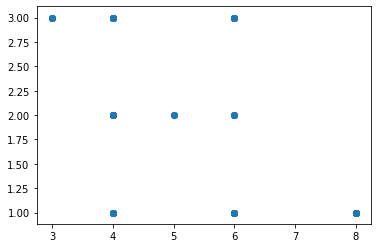

In [6]:
# CHI-SQUARE TEST
plt.scatter(df['cylinders'], df['origin'])
even_df = df[df['cylinders']%2!=1]
print(df.shape[0] - even_df.shape[0], 'out of', df.shape[0], 'data points removed')
from itertools import product

cylinders = sorted(even_df['cylinders'].unique())
years = sorted(even_df['model year'].unique())

# header row
print('Observed')
print('        | ', end='')
for year in list(years) + ['Total']: print(f'{year:^6} | ', end='')
print('\n' + '='*(9+9+9*len(years)))

table_obs = []
for cylinder in cylinders:
    table_obs.append([])
    print(f'{cylinder:7d} | ', end='')
    for year in years:
        table_obs[-1].append(np.sum(np.logical_and( even_df["cylinders"].values==cylinder, even_df["model year"].values==year )))
        print(f'{table_obs[-1][-1]:6d} | ', end='')
    print(f'{sum(table_obs[-1]):6d} | ', end='')
    print()

print(f'{"Total":7} | ', end='')
for i, year in enumerate(years):
    print(f'{sum(row[i] for row in table_obs):6d} | ', end='')
print(f'{sum(table_obs[-1]):6d} | ')
    
# chi^2, p-val, df
results = chi2_contingency(table_obs)
print('\nchi^2 = {:.3f}\np-val = {:.3f}\n  df  = {:.3f}\n'.format(*results[:3]))
print('Expected')
print('   | ', end='')
for year in years: print(f'{year:^6d} | ', end='')
print('\n' + '='*(4+9*len(years)))
for cylinder, row in zip(cylinders, results[3]):
    print(f'{cylinder:2d} | ', end='')
    for year, cell in zip(years, row):
        print(f'{cell:6.3f} | ', end='')
    print()

# 3. Dimensionality reduction
Principal Components Analysis (PCA)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale

X, y = df[['displacement', 'horsepower', 'weight', 'acceleration', 'model year']], df['mpg']

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)


# 4. Regession (Prediction of `mpg`)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

NameError: name 'train_test_split' is not defined

In [ ]:
# LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# For illustration
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
fstring = 'mpg = {0:.3f} {1:+.3f}*displacement {1:+.3f}*horsepower {2:+.3f}*weight {3:+.3f}*acceleration {1:+.3f}*model_year'
print(fstring.format(model.intercept_, *model.coef_))
print(f'r^2 = {r2_score(y_test, prediction):.3f}')

printmd('\n**Test Results**')
print(pd.DataFrame({
    'predicted mpg': prediction,
    'actual mpg': y_test
}), '', sep='\n')

# For evaluation
printmd('\n**A less partial evaluation**')
model = LinearRegression()
print(f'r^2 = {cross_val_score(model, X, y).mean():.3f}')

In [ ]:
# Neural networks WITHOUT scaling
from sklearn.neural_network import MLPRegressor

# For illustration
model = MLPRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f'score = {model.score(X_test, y_test):.3f}')

printmd('\n**Test Results**')
print(pd.DataFrame({
    'predicted mpg': prediction,
    'actual mpg': y_test
}), '', sep='\n')

# For evaluation
printmd('\n**A less partial evaluation**')
model = MLPRegressor()
print(f'score = {cross_val_score(model, X, y).mean():.3f}')

In [ ]:
# Neural networks WITH scaling, comparing different hidden-layer settings
from sklearn.pipeline import Pipeline

for size in [(10,), (20,), (10,10), (20,20), (10,10,10), (20,20,20)]:
    pipeline_eval = Pipeline([
        ('scale', StandardScaler()),
        ('NN', MLPRegressor(hidden_layer_sizes=size, max_iter=2000)),
    ])
    # For evaluation
    print(f'{str(size):15} r^2 = {cross_val_score(pipeline_eval, X, y).mean():.3f}')

The best r^2 score is 0.424.
Neural networks of (20,) predict the `origin` best. Scaling improves results (from 0.638 to 0.722) as expected.

# 5. Classification (of `origin`)

In [ ]:
X, y = df[['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']], df['origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
# Neural networks WITHOUT scaling
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# For illustration
model = MLPClassifier(hidden_layer_sizes=(10,))
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f'score = {model.score(X_test, y_test):.3f}')

printmd('\n**Test Results**')
print(pd.DataFrame({
    'predicted origin': prediction,
    'actual origin': y_test
}), '', sep='\n')

# For evaluation
printmd('\n**A less partial evaluation**')
model = MLPClassifier(hidden_layer_sizes=(10,))
print(f'score = {cross_val_score(model, X, y).mean():.3f}')

In [ ]:
# Neural networks WITH scaling, comparing different hidden-layer settings
for size in [(10,), (20,), (10,10), (20,20), (10,10,10), (20,20,20)]:
    pipeline_eval = Pipeline([
        ('scale', StandardScaler()),
        ('NN', MLPClassifier(hidden_layer_sizes=size, max_iter=2000)),
    ])
    # For evaluation
    print(f'{str(size):15} r^2 = {cross_val_score(pipeline_eval, X, y).mean():.3f}')

The best r^2 score is 0.722.
Neural networks of (10,) and (10, 10, 10) predict the `origin` best. Scaling improves results (from 0.638 to 0.722) as expected.

# 6. Clustering

In [ ]:
from sklearn.manifold import TSNE
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['origin'])

# 7. Conclusions
Many of the features are highly correlated.
Scaling before using neural networks improves performance, from __ to __ for regression and from __ to __ for classification.